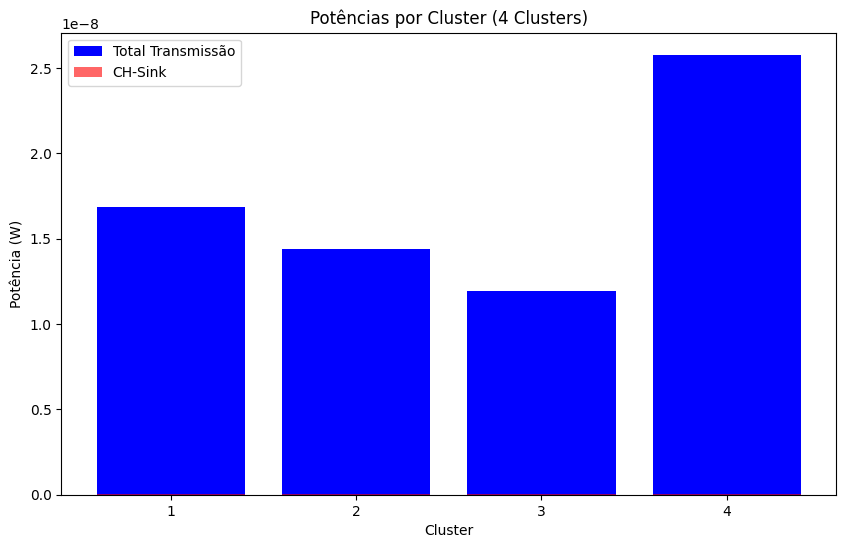

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

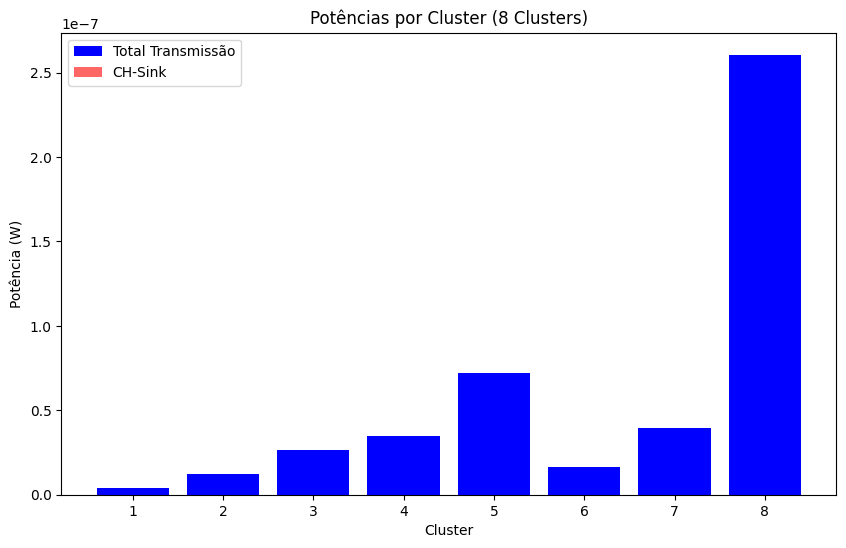

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

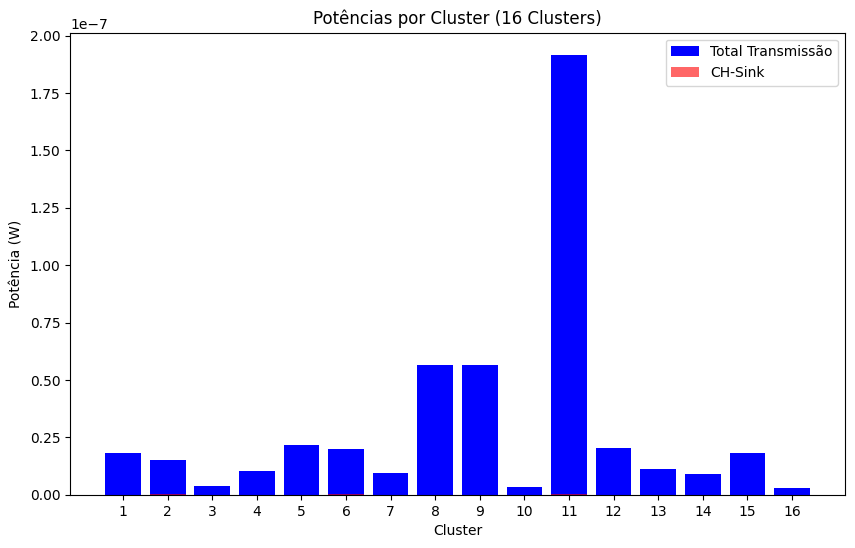

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

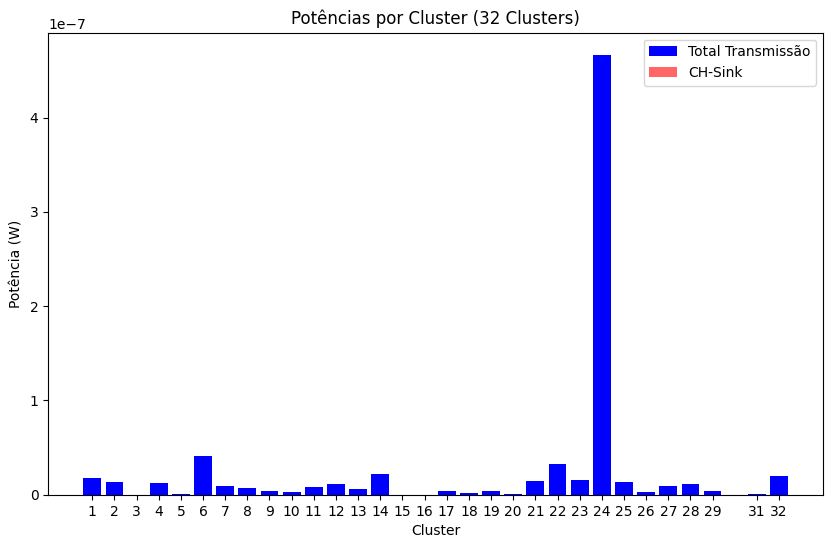

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

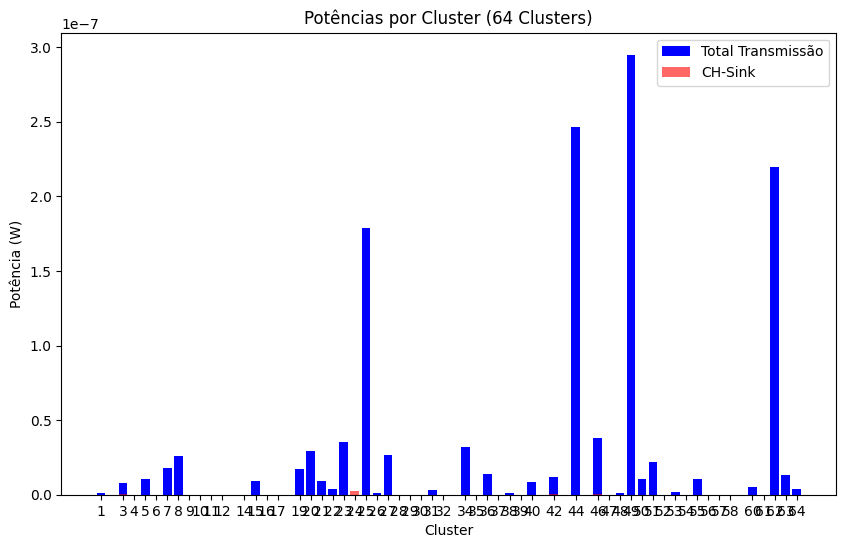

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

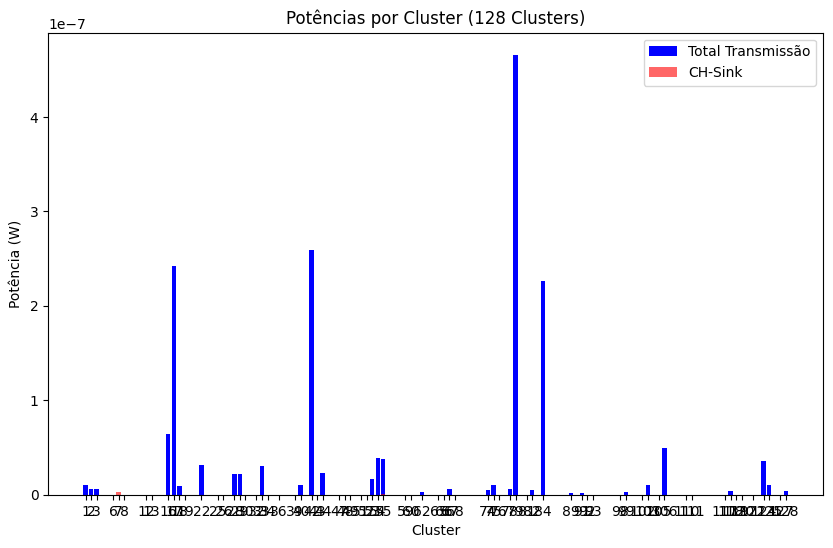

$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$

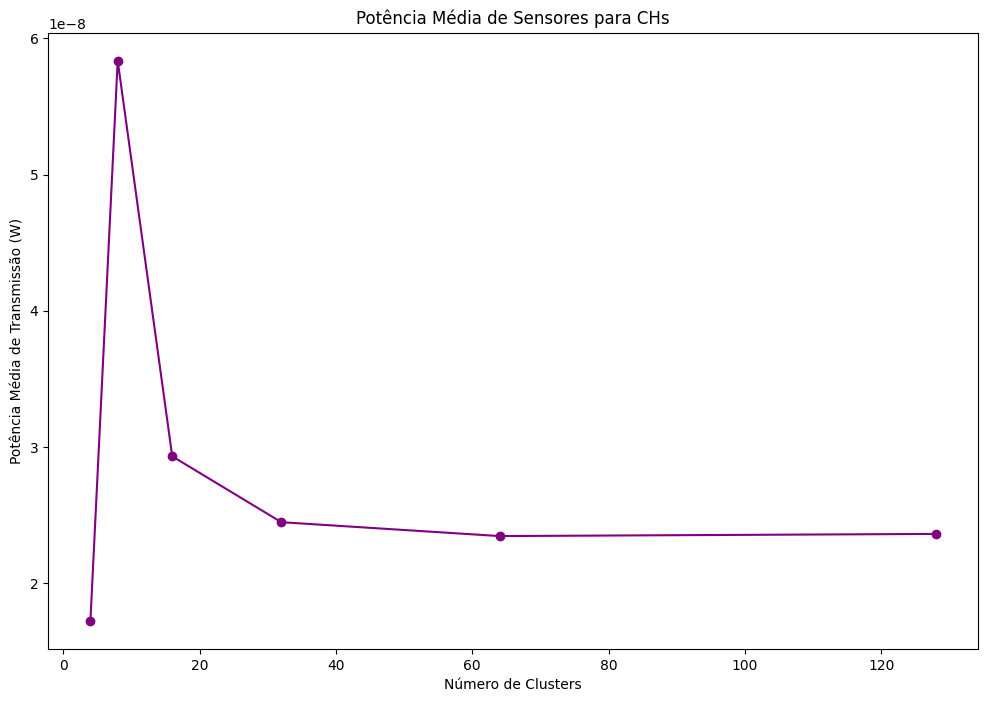

$\text{Potência Média} = \frac{\text{Potência Total de Transmissão}}{\text{Número de Sensores}}$

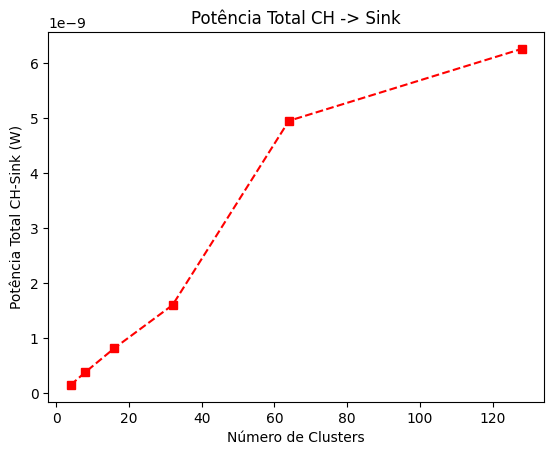

$\text{Potência Total CH-Sink} = \sum \text{Potência CH-Sink}$

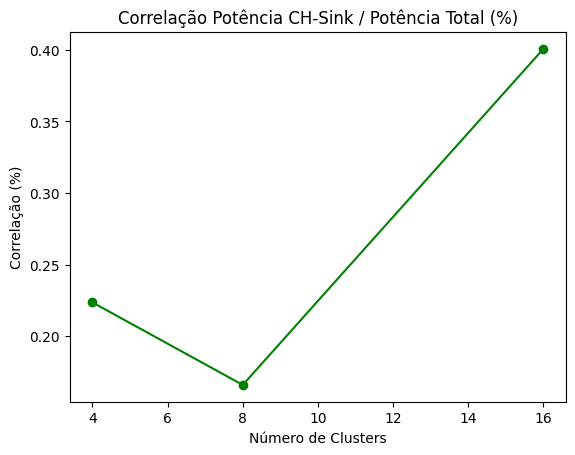

$\text{Correlação CH-Sink/Total} = \frac{\text{Potência CH-Sink}}{\text{Potência Total}} \times 100$

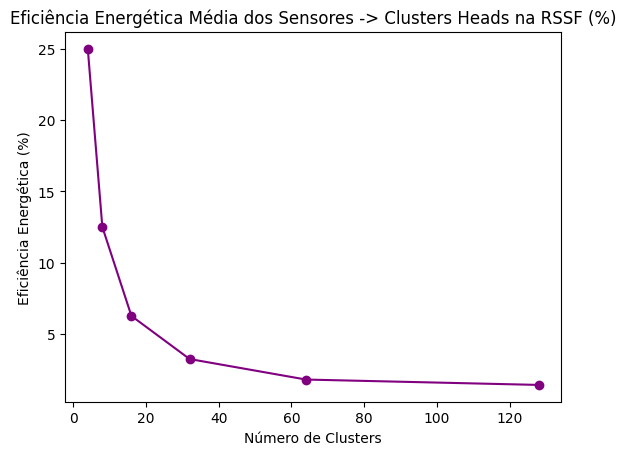

$\text{Eficiência Média Sensores-CH} = \frac{\text{Potência Média Sensores}}{\text{Potência Total}} \times 100$

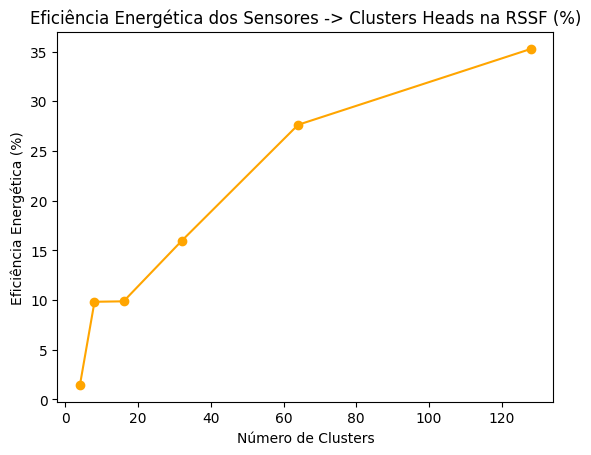

$\text{Eficiência Sensores-CH} = \frac{\text{Potência Total Sensores}}{\text{Potência Total}} \times 100$

Finalizado: 02/01/2025 15:45:08


In [2]:
#!/usr/bin/env python
# coding: utf-8
"""
Programa: simulaclusters_V6.py
Simulação de uma Rede de Sensores Inteligentes em clusters, baseada no método K-Means e na Lei de Friis, com controle de eficiência energética.
@author: Maurício Brigato
Mestrado em Engenharia Elétrica FESJ ICTS
Unesp Universidade Estadual Paulista "Júlio de Mesquita Filho"
date: 25/10/2024
"""
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from IPython.display import display, Markdown

# Definir caminho para salvar os gráficos
save_path = r'C:\Users\mauri\Documents\Mestrado_OFICIAL\DEFESA_MESTRADO\comparaclusters'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Funções auxiliares e de cálculo
def minkowski_distance(point, center, lamb):
    return sum(abs(point[k] - center[k]) ** lamb for k in range(len(point))) ** (1 / lamb)

def generate_points(tot_sensors, limit):
    return [(random.uniform(0, limit), random.uniform(0, limit)) for _ in range(tot_sensors)]

def calculate_distance(x1, x2, y1, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def friis_transmission_power(pt, gt, gr, lambda_, d):
    return pt * (gt * gr * (lambda_ / (4 * math.pi * d)) ** 2) if d > 0 else 0

def find_cluster_head(cluster, centroid):
    return min(cluster, key=lambda point: calculate_distance(point[0], centroid[0], point[1], centroid[1]))

def simulate_clusters(num_clusters, points, sink_position, lambda_, gt, gr, pt_transceiver):
    centroids = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(num_clusters)]
    clusters = [[] for _ in range(num_clusters)]

    while True:
        new_clusters = [[] for _ in range(num_clusters)]
        for x, y in points:
            distances = [minkowski_distance((x, y), centroid, 1) for centroid in centroids]
            cluster_idx = distances.index(min(distances))
            new_clusters[cluster_idx].append((x, y))

        new_centroids = []
        for i, cluster in enumerate(new_clusters):
            if cluster:
                mean_x = sum(x for x, y in cluster) / len(cluster)
                mean_y = sum(y for x, y in cluster) / len(cluster)
                new_centroids.append((mean_x, mean_y))
            else:
                new_centroids.append(centroids[i])

        if all(math.isclose(new_centroids[i][0], centroids[i][0], abs_tol=1e-3) and
               math.isclose(new_centroids[i][1], centroids[i][1], abs_tol=1e-3) for i in range(num_clusters)):
            break
        centroids = new_centroids
        clusters = new_clusters

    cluster_powers = []
    for i, cluster in enumerate(clusters):
        if cluster:
            cluster_head = find_cluster_head(cluster, centroids[i])
            total_transmission_power = sum(
                friis_transmission_power(pt_transceiver, gt, gr, lambda_, calculate_distance(sensor[0], cluster_head[0], sensor[1], cluster_head[1]))
                for sensor in cluster if calculate_distance(sensor[0], cluster_head[0], sensor[1], cluster_head[1]) > 0)
            d_to_sink = calculate_distance(cluster_head[0], sink_position[0], cluster_head[1], sink_position[1])
            ch_to_sink_power = friis_transmission_power(pt_transceiver, gt, gr, lambda_, d_to_sink)
            cluster_powers.append({
                'cluster_index': i + 1,
                'cluster_head': cluster_head,
                'total_transmission_power': total_transmission_power,
                'ch_to_sink_power': ch_to_sink_power,
                'distance_to_sink': d_to_sink,
                'total_sensors': len(cluster)
            })

    return cluster_powers

# Código principal
def main():
    FREQ = 2.4 * 10**9
    Pt_transceiver = 0.001
    LAMBDA = 299792458 / FREQ
    GT = 1.0
    GR = 1.0
    sink_position = (100, 50)
    totSensors = 128
    points = generate_points(totSensors, 100)
    cluster_sizes = [4, 8, 16, 32, 64, 128]

    all_cluster_data = {}
    for num_clusters in cluster_sizes:
        cluster_data = simulate_clusters(num_clusters, points, sink_position, LAMBDA, GT, GR, Pt_transceiver)
        all_cluster_data[num_clusters] = {'data': cluster_data}

    df_all_data = pd.concat(
        [pd.DataFrame(all_cluster_data[nc]['data']).assign(Clusters=nc) for nc in cluster_sizes],
        ignore_index=True
    )

    # Gráfico 1 a 6: Potências por Cluster
    for num_clusters in cluster_sizes:
        subset = df_all_data[df_all_data['Clusters'] == num_clusters]
        fig, ax = plt.subplots(figsize=(10, 6))
        indices = subset['cluster_index'].astype(int)
        ax.bar(indices, subset['total_transmission_power'], label="Total Transmissão", color='blue')
        ax.bar(indices, subset['ch_to_sink_power'], label="CH-Sink", color='red', alpha=0.6)
        ax.set_title(f"Potências por Cluster ({num_clusters} Clusters)")
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Potência (W)")
        ax.legend()
        ax.set_xticks(indices)
        plt.savefig(os.path.join(save_path, f"Potencias_{num_clusters}Clusters.png"), bbox_inches='tight')
        plt.show()
        display(Markdown(r"$\text{Potência Total por Cluster} = \text{Potência Transmissão Sensor} + \text{Potência CH-Sink}$"))

    # Gráfico 7: Potência média de Sensores para CHs
    fig, ax = plt.subplots(figsize=(12, 8))
    avg_power_per_sensor = df_all_data.groupby('Clusters')['total_transmission_power'].mean()
    ax.plot(avg_power_per_sensor.index, avg_power_per_sensor.values, marker='o', linestyle='-', color='purple')
    ax.set_title("Potência Média de Sensores para CHs")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Potência Média de Transmissão (W)")
    plt.savefig(os.path.join(save_path, "Potencia_Media_Sensores.png"))
    plt.show()
    display(Markdown(r"$\text{Potência Média} = \frac{\text{Potência Total de Transmissão}}{\text{Número de Sensores}}$"))

    # Gráfico 8: Potência Total CH -> Sink
    fig, ax = plt.subplots()
    ch_sink_power_total = df_all_data.groupby('Clusters')['ch_to_sink_power'].sum()
    ax.plot(ch_sink_power_total.index, ch_sink_power_total.values, marker='s', linestyle='--', color='red')
    ax.set_title("Potência Total CH -> Sink")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Potência Total CH-Sink (W)")
    plt.savefig(os.path.join(save_path, "Potencia_Total_CH_Sink.png"))
    plt.show()
    display(Markdown(r"$\text{Potência Total CH-Sink} = \sum \text{Potência CH-Sink}$"))

    # Gráfico 9: Correlação Potência CH-Sink / Potência Total (%)
    df_all_data['Relacao_CH_Sink_Potencia_Total'] = (df_all_data['ch_to_sink_power'] / df_all_data['total_transmission_power']) * 100
    fig, ax = plt.subplots()
    correlation = df_all_data.groupby('Clusters')['Relacao_CH_Sink_Potencia_Total'].mean()
    ax.plot(correlation.index, correlation.values, marker='o', linestyle='-', color='green')
    ax.set_title("Correlação Potência CH-Sink / Potência Total (%)")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Correlação (%)")
    plt.savefig(os.path.join(save_path, "Relacao_Potencia_CH_Sink_Total.png"))
    plt.show()
    display(Markdown(r"$\text{Correlação CH-Sink/Total} = \frac{\text{Potência CH-Sink}}{\text{Potência Total}} \times 100$"))

    # Gráfico 10: Eficiência Energética Média dos Sensores -> Clusters Heads
    fig, ax = plt.subplots()
    avg_efficiency = (df_all_data.groupby('Clusters')['total_transmission_power'].mean() / df_all_data.groupby('Clusters')['total_transmission_power'].sum()) * 100
    ax.plot(avg_efficiency.index, avg_efficiency.values, marker='o', linestyle='-', color='purple')
    ax.set_title("Eficiência Energética Média dos Sensores -> Clusters Heads na RSSF (%)")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Eficiência Energética (%)")
    plt.savefig(os.path.join(save_path, "Eficiencia_Energetica_Media_Sensores.png"))
    plt.show()
    display(Markdown(r"$\text{Eficiência Média Sensores-CH} = \frac{\text{Potência Média Sensores}}{\text{Potência Total}} \times 100$"))

    # Gráfico 11: Eficiência Energética dos Sensores -> Clusters Heads
    fig, ax = plt.subplots()
    total_sensor_to_ch_efficiency = (df_all_data.groupby('Clusters')['total_transmission_power'].sum() / df_all_data['total_transmission_power'].sum()) * 100
    ax.plot(total_sensor_to_ch_efficiency.index, total_sensor_to_ch_efficiency.values, marker='o', linestyle='-', color='orange')
    ax.set_title("Eficiência Energética dos Sensores -> Clusters Heads na RSSF (%)")
    ax.set_xlabel("Número de Clusters")
    ax.set_ylabel("Eficiência Energética (%)")
    plt.savefig(os.path.join(save_path, "Eficiencia_Energetica_Sensores_Clusters_Heads.png"))
    plt.show()
    display(Markdown(r"$\text{Eficiência Sensores-CH} = \frac{\text{Potência Total Sensores}}{\text{Potência Total}} \times 100$"))

    print("Finalizado:", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

if __name__ == "__main__":
    main()
